# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IOT)

### Input - Entrada

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelidade 
2. Conjunto de dados
    - Venda de um ecommerce online, durante período de um ano

### Output - Saída

1. Indicação das pessoas que farão parte do programa Insiders
    - Lista:    client id | is_insider |
            4967        yes
            5488        no
2. Relatório com as respostas das perguntas de negócio
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento que vem do Insiders?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao Insiders?
    - Quais as condições para uma pessoa ser removida do Insiders?
    - Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Quais ações o time de marketing pode fazer para aumentar o faturamento?

### Tasks - Tarefas

   1. Quem são as pessoas elegíveis para participar do programa Insiders?
       - O que são clientes mais valiosos para a empresa?
       - Faturamento
           - Alto ticket médio
           - Alto LTV (a soma de tudo que a pessoa gastou)
           - Baixa recência
           - Alto basket size
           - Baixa probabilidade de churn
           - Alta previsão de LTV
           - Alta propensão de compra
       - Custo
           - Baixa taxa de devolução
       - Experiência de compra
           - Média alta nas avaliações
   
   2. Quantos clientes farão parte do grupo?
       - Número total de clientes
       - % do grupo Insiders
   
   3. Quais as principais características desses clientes?
       - Escrever características do cliente
           - Idade
           - Localização
       - Escrever características do consumo
           - Features/atributos da clusterização
   
   4. Qual a porcentagem de contribuição do faturamento que vem do Insiders?
       - Faturamento total do ano
       - Faturamento do grupo Insiders
   
   5. Qual a expectativa de faturamento desse grupo para os próximos meses?
       - LTV do grupo Insiders
       - Análise de cohort
   
   6. Quais as condições para uma pessoa ser elegível ao Insiders?
       - Definir periodicidade (exemplo: 1 mês, 3 meses)
       - A pessoa precisa ser similar com uma pessoa do grupo
   
   7. Quais as condições para uma pessoa ser removida do Insiders?
       - Definir periodicidade (exemplo: 1 mês, 3 meses)
       - A pessoa precisa ser desimilar com uma pessoa do grupo
   
   8. Qual a garantia que o programa Insiders é melhor que o restante da base?
       - Teste A/B
       - Teste A/B Bayesiano
       - Teste de hipótese
   
   9. Quais ações o time de marketing pode fazer para aumentar o faturamento?
       - Desconto
       - Preferência de compra
       - Frete
       - Visita à empresa

## 0.0. Imports

In [63]:
import pandas  as pd
import numpy   as np
import seaborn as sns

from IPython.display       import HTML
from matplotlib            import pyplot  as plt
from sklearn               import cluster as c
from sklearn               import metrics as m
from plotly                import express as px
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
def isnumber(value):
    try:
        int(value)
    except ValueError:
        return False
    return True

## 0.2. Loading dataset

In [5]:
pwd

'C:\\Users\\aline.moraes\\Documents\\Aprendizado_continuo\\Comunidade_DS\\PA05_clusterizacao_UK\\insiders_clustering\\notebook'

In [6]:
# load data
df_raw = pd.read_csv('Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw.drop(['Unnamed: 8'], axis=1, inplace=True)

In [7]:
df_raw.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.0. Descrição dos dados

In [8]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [9]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [10]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

In [11]:
df1.columns = cols_new
df1.head(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.2. Data Dimensios

In [12]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types

In [13]:
df1.info()

# invoice_no e stock_code deveriam ser int
# invoice_date deveria ser datetime
# customer_id deveria ser int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 1.4. Check NA

In [14]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [15]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print(f'Removed data: {(1 - (df1.shape[0]/df_raw.shape[0]))*100 :.2f}%')

Removed data: 24.93%


In [16]:
df1.shape[0]

406829

In [17]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtypes

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    406829 non-null  object 
 1   stock_code    406829 non-null  object 
 2   description   406829 non-null  object 
 3   quantity      406829 non-null  int64  
 4   invoice_date  406829 non-null  object 
 5   unit_price    406829 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [19]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']) #format='%Y-%m-%d'

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int) 

# Alteração do invoice_no e stock_code tem letras misturadas com os números, vamos tratar mais para frente

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    406829 non-null  object        
 1   stock_code    406829 non-null  object        
 2   description   406829 non-null  object        
 3   quantity      406829 non-null  int64         
 4   invoice_date  406829 non-null  datetime64[ns]
 5   unit_price    406829 non-null  float64       
 6   customer_id   406829 non-null  int32         
 7   country       406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.4+ MB


## 1.7. Descriptive Statistics

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    406829 non-null  object        
 1   stock_code    406829 non-null  object        
 2   description   406829 non-null  object        
 3   quantity      406829 non-null  int64         
 4   invoice_date  406829 non-null  datetime64[ns]
 5   unit_price    406829 non-null  float64       
 6   customer_id   406829 non-null  int32         
 7   country       406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.4+ MB


In [21]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'int32', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [22]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.1.1 Numerical Attributes Investigating

1. Quantidade negativa
2. Preço unitário igual a zero

In [24]:
df1[df1['quantity'] <= 0].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom


In [34]:
rows = df1[df1['quantity'] <= 0].shape[0]
print(f'{rows} registros com quantidade < 0\nAlguns estão como Discont na descrição e outros com C no início de invoice, indicando um possível cancelamento/cancel ou alteração/change')

8905 registros com quantidade < 0
Alguns estão como Discont na descrição e outros com C no início de invoice, indicando um possível cancelamento/cancel ou alteração/change


In [39]:
df1[df1['unit_price'] == 0].sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2017-01-04,0.0,13081,United Kingdom
314745,564651,23270,SET OF 2 CERAMIC PAINTED HEARTS,96,2017-08-24,0.0,14646,Netherlands
479546,577168,M,Manual,1,2017-11-16,0.0,12603,Germany
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2017-01-11,0.0,15107,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2017-04-02,0.0,14410,United Kingdom


In [41]:
rows = df1[df1['unit_price'] == 0].shape[0]
print(f'{rows} registros com preço igual a zero\nAlguns estão como Manual na descrição, mas a maioria apresenta informações coerentes em invoice_no, stock_code e description')

40 registros com preço igual a zero
Alguns estão como Manual na descrição, mas a maioria apresenta informações coerentes em invoice_no, stock_code e description


### 1.7.2 Categorical Attributes

In [42]:
cat_attributes.sample(3)

# invoice_no e stock_code não deveria estar como categórico, mas estão pq há alguns registros com letras

,invoice_no,stock_code,description,country
239243,558035,22692,DOORMAT WELCOME TO OUR HOME,United Kingdom
383107,569998,22045,SPACEBOY GIFT WRAP,Spain
314572,564643,23302,KNEELING MAT HOUSEWORK DESIGN,United Kingdom


In [43]:
cat_attributes['check_invoice_no'] = cat_attributes['invoice_no'].apply(isnumber)
cat_attributes['check_stock_code'] = cat_attributes['stock_code'].apply(isnumber)

In [44]:
cat_attributes[cat_attributes['check_invoice_no'] == False].shape[0]

# número de registros em invoice_no que tem pelo menos 1 letra

8905

In [45]:
cat_attributes[cat_attributes['check_stock_code'] == False].shape[0]

# número de registros em stock_code que tem pelo menos 1 letra

35809

In [46]:
cat_attributes.shape[0]

# número total de registros

406829

## 2.0. Filtragem de Variáveis

In [47]:
df2 = df1.copy()

In [48]:
# separar dataset em purchase e devolution

df2_devolution = df2[df2['quantity'] <= 0]
df2_purchase = df2[(df2['quantity'] > 0) & (df2['unit_price'] > 0)]

## 3.0. Feature Engineering

In [73]:
df3 = df2_purchase.copy()

## 3.1. Feature Creation

In [74]:
df3.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [75]:
# data reference
# como o objetivo é clusterizar nossos clientes, o df_ref terá os unique customers_id 

df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [76]:
print(f'Temos {df_ref.shape[0]} clientes na base')

Temos 4338 clientes na base


### 3.1.1 Monetary

In [77]:
# Gross Revenue (quantity*price = Faturamento)
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

In [78]:
# Monetary
df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary.head()

,customer_id,gross_revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [79]:
df_ref = df_ref.merge(df_monetary, how='left', on='customer_id')
df_ref.head()

,customer_id,gross_revenue
0,17850,5391.21
1,13047,3237.54
2,12583,7281.38
3,13748,948.25
4,15100,876.00


### 3.1.2 Recency

In [80]:
# registro mais recente do dataset
df3['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [81]:
# Recency (last day purchase)
df3['recency_in_days'] = (df3['invoice_date'].max() - df3['invoice_date']).dt.days
df3.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue,recency_in_days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34,373


In [82]:
df_recency = df3[['customer_id', 'recency_in_days']].groupby('customer_id').min().reset_index()
df_recency.head()

,customer_id,recency_in_days
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [83]:
df_ref = df_ref.merge(df_recency, how='left', on='customer_id')
df_ref.head()

,customer_id,gross_revenue,recency_in_days
0,17850,5391.21,372
1,13047,3237.54,31
2,12583,7281.38,2
3,13748,948.25,95
4,15100,876.00,333


### 3.1.3 Frequency

In [84]:
#Quantas vezes já comprou com a gente

df_frequency = df3[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index()
df_frequency.columns = ['customer_id', 'frequency']
df_frequency.head()

,customer_id,frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [85]:
df_ref = df_ref.merge(df_frequency, how='left', on='customer_id')
df_ref.head()

,customer_id,gross_revenue,recency_in_days,frequency
0,17850,5391.21,372,297
1,13047,3237.54,31,172
2,12583,7281.38,2,247
3,13748,948.25,95,28
4,15100,876.00,333,3


### 3.1.4 Avg Ticket

In [86]:
df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = df_ref.merge(df_avg_ticket, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency_in_days,frequency,avg_ticket
0,17850,5391.21,372,297,18.152222
1,13047,3237.54,31,172,18.822907
2,12583,7281.38,2,247,29.479271
3,13748,948.25,95,28,33.866071
4,15100,876.00,333,3,292.000000


## 4.0. EDA (Exploratory Data Analysis)

In [87]:
df4 = df_ref.copy()

## 5.0. Data Preparation

In [88]:
df5 = df4.copy()

In [90]:
mms = MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform( df5[['gross_revenue']].values )
df5['recency_in_days'] = mms.fit_transform( df5[['recency_in_days']].values )
df5['frequency'] = mms.fit_transform( df5[['frequency']].values )
df5['avg_ticket'] = mms.fit_transform( df5[['avg_ticket']].values )


## 6.0. Feature Selection

## 7.0. Hyperparameter Fine-Tuning

In [91]:
df7 = df5.copy()
df7.head()

,customer_id,gross_revenue,recency_in_days,frequency,avg_ticket
0,17850,0.019227,0.997319,0.037726,0.000208
1,13047,0.011541,0.083110,0.021795,0.000217
2,12583,0.025973,0.005362,0.031354,0.000355
3,13748,0.003371,0.254692,0.003441,0.000412
4,15100,0.003113,0.892761,0.000255,0.003756


In [92]:
X = df7.drop('customer_id', axis=1)

In [93]:
clusters = [2, 3, 4, 5, 6]

## 7.1. Within-Cluster Sum of Square (WSS)

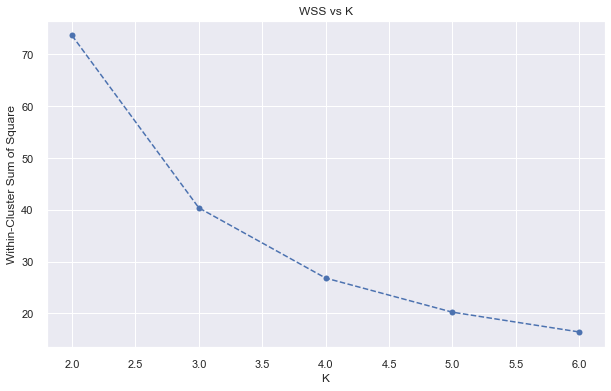

In [94]:
wss = []
for k in clusters:
    
    #model definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42  ) #init random significa que o modelo vai começar aleatoriamente procurando grupos com um centroide específico, deixamos n_init = 10 pra ele fazer 10x e não pegar o primeiro que pode não representar um bom cluster
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method
figure(figsize=(10,6))
plt.plot( clusters, wss, linestyle='--', marker='o' );
plt.xlabel( 'K' );
plt.ylabel( 'Within-Cluster Sum of Square' );
plt.title( 'WSS vs K' );

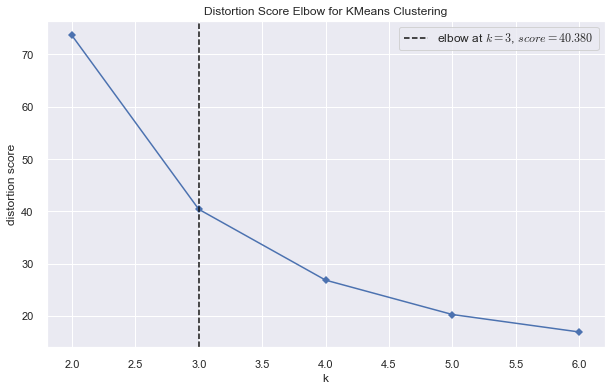

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
# outra forma de encontrar o k pelo WSS
figure(figsize=(10,6))
kmeans = KElbowVisualizer( c.KMeans(), k = clusters, timings=False )
kmeans.fit( X )
kmeans.show()

## 7.2. Silhouette Score

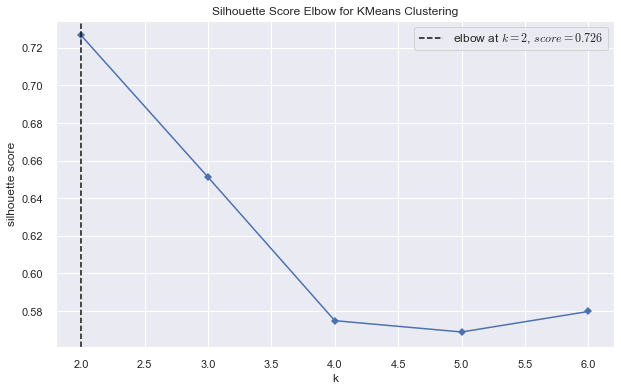

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [97]:
figure(figsize=(10,6))
kmeans = KElbowVisualizer( c.KMeans(), k = clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

# quanto mais próximo a silhouette de 1, melhor. Significa que os clusters estão distantes entre si

## 7.3. Silhouette Analysis

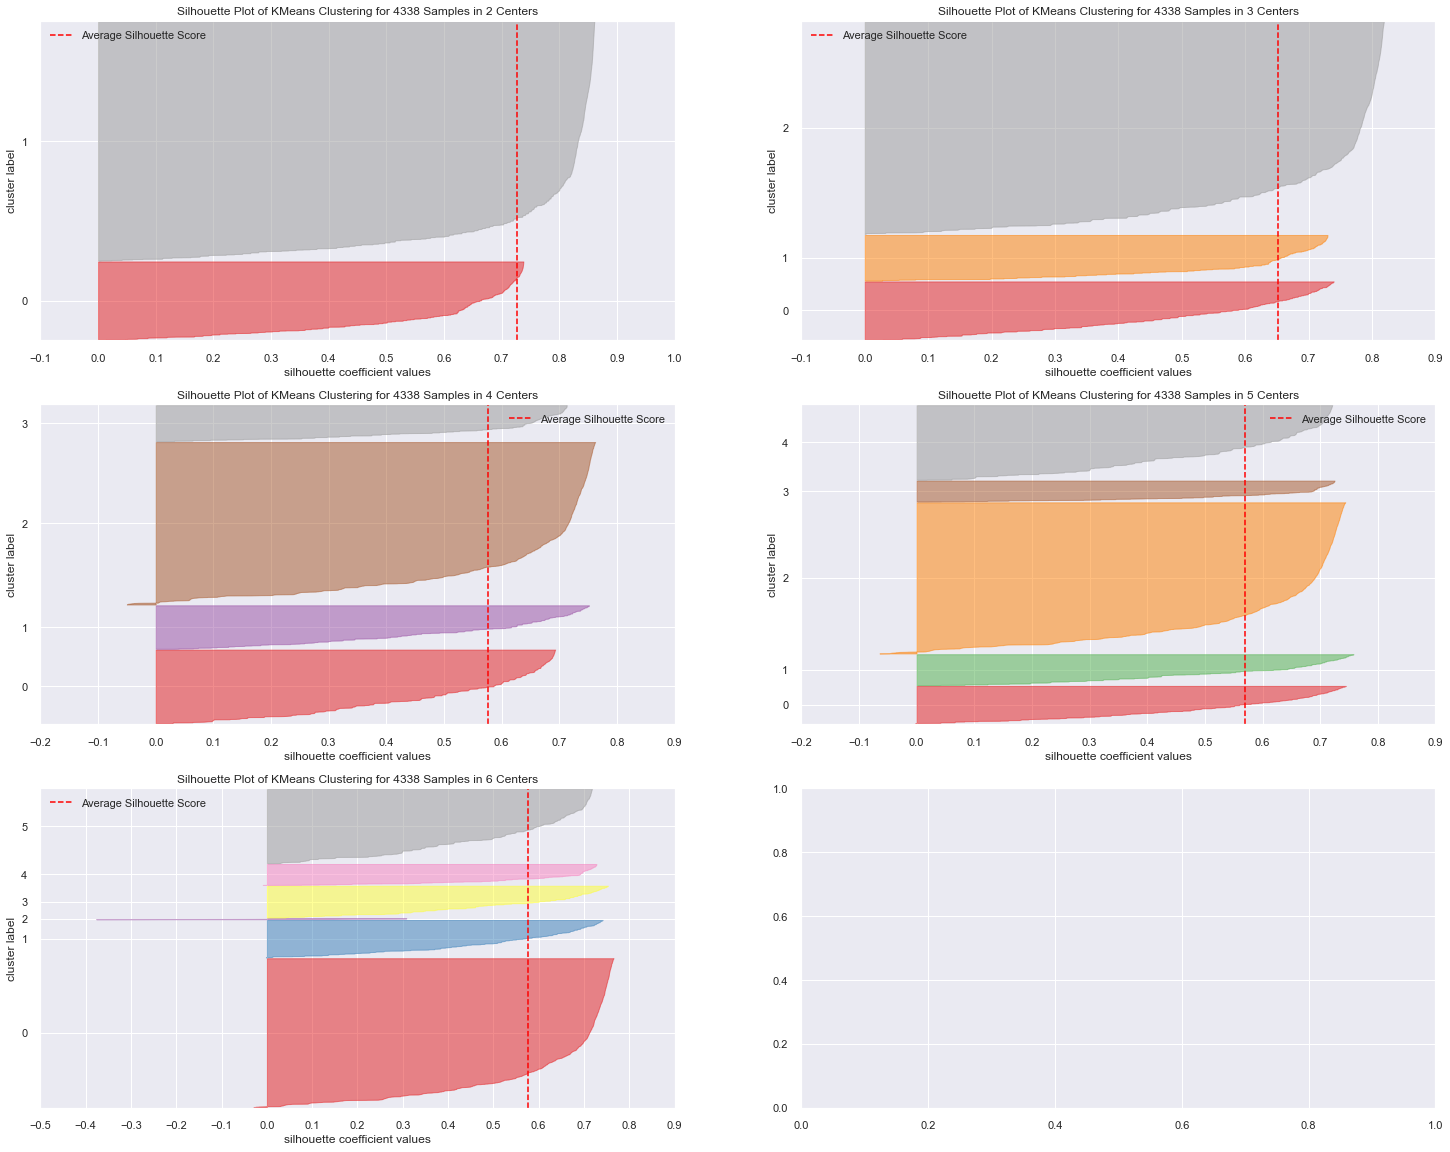

In [98]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 20) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod(k, 2) # q é linha e mod é a coluna; 2 é o mín entre nossos valores (moda é o resto) k (p/ k=2) divido por 2 dá 1 e o resto é zero [1][0]; k (p/ k=3) dividido por 2 dá 1 e o resto 1 [1][1]
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## 8.0. Model Training

### 8.1. K-Means

In [99]:
# model definition
k = 2
kmeans = c.KMeans(init = 'random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
#labels = kmeans.predict(X)
labels = kmeans.labels_

### 8.2. Cluster Validation

In [100]:
# WSS Within-Cluster Sum of Square
print(f'WSS: {kmeans.inertia_}')

# SS Silhouette Score
print('SS: {}'.format( m.silhouette_score(X, labels, metric='euclidean') ))

WSS: 73.63339204159949
SS: 0.7264444873057613


## 9.0. Cluster Analysis

In [101]:
df9 = df7.copy()

In [102]:
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_in_days,frequency,avg_ticket,cluster
0,17850,0.019227,0.997319,0.037726,0.000208,0
1,13047,0.011541,0.083110,0.021795,0.000217,1
2,12583,0.025973,0.005362,0.031354,0.000355,1
3,13748,0.003371,0.254692,0.003441,0.000412,1
4,15100,0.003113,0.892761,0.000255,0.003756,0


### 9.1. Visualization Inspection

In [103]:
# é possível apenas com 3 features

#fig = px.scatter_3d(df9, x='recency_in_days', y='frequency', z='gross_revenue', color='cluster')
#fig.show()

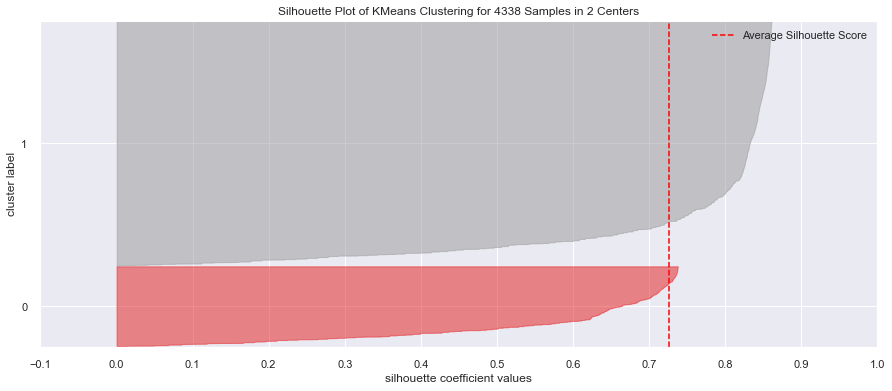

In [104]:
k = 2
figure(figsize=(15,6))

km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
visualizer = SilhouetteVisualizer( km, color='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

### 9.2. 2d plot

In [105]:
df9.head()

,customer_id,gross_revenue,recency_in_days,frequency,avg_ticket,cluster
0,17850,0.019227,0.997319,0.037726,0.000208,0
1,13047,0.011541,0.083110,0.021795,0.000217,1
2,12583,0.025973,0.005362,0.031354,0.000355,1
3,13748,0.003371,0.254692,0.003441,0.000412,1
4,15100,0.003113,0.892761,0.000255,0.003756,0


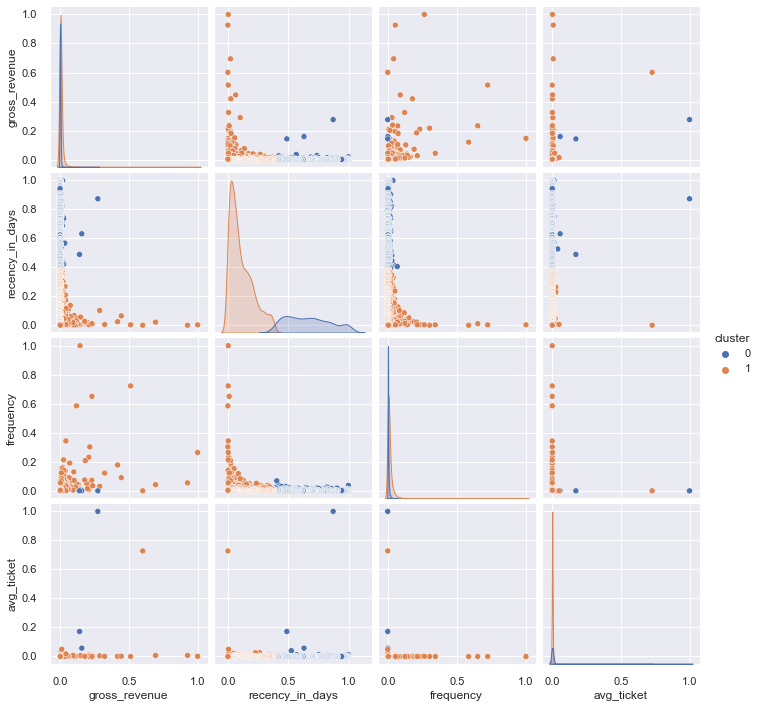

In [106]:
df_viz = df9.drop('customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### 9.3. Cluster Profile

In [107]:
# Number of clusters
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer_%'] = round((df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100,2)

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index() 
df_cluster = df_cluster.merge(df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency day
df_avg_recency_day = df9[['recency_in_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_recency_day, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer_%,gross_revenue,recency_in_days,frequency,avg_ticket
0,0,1069,24.64,0.002304,0.664726,0.003607,0.001595
1,1,3269,75.36,0.008958,0.110144,0.014164,0.000617


**Cluster 0**
1. x% na base
2. Clientes já gastaram em média $ x
3. Clientes ficam em média x meses sem comprar
4. Já compraram x produtos
5. Tem ticket médio de x

**Cluster 1 (Candidatos ao Insider)**
1. x
2. x
3. x
4. x

**Cluster 2**
1. x
2. x
3. x
4. x

## 10.0. Deploy